In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
var_origin = pd.read_csv('./data/bike/basic_model_df.csv')
var_origin = var_origin.drop(columns=['Unnamed: 0'])
var_origin.head(5)

,cluster,month,day,weekday,hour,demands
0,0,1,1,1,0,2
1,0,1,1,1,1,1
2,0,1,1,1,2,2
3,0,1,1,1,3,0
4,0,1,1,1,4,0


In [82]:
from sklearn.preprocessing import MinMaxScaler

X = var_origin.drop(labels=['demands'], axis=1).copy()
Y = var_origin['demands'].values.copy()
test = var_origin[(var_origin['month']==9)&(var_origin['day']==30)]
test_index = var_origin[(var_origin['month']==9)&(var_origin['day']==30)].index
train = var_origin.drop(index = test_index,axis=1).reset_index(drop=True)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

scaler_X.fit(X)
scaler_Y.fit(Y.reshape(-1,1))

x_train = scaler_X.transform(train.drop(labels=['demands'], axis=1).copy())
y_train = scaler_Y.transform(train['demands'].values.copy().reshape(-1,1))

x_test = scaler_X.transform(test.drop(labels=['demands'], axis=1).copy())
y_test = scaler_Y.transform(test['demands'].values.copy().reshape(-1,1))

In [65]:
from matplotlib import pyplot as plt
def show_graph(y_hat,y):
    clusters = [i for i in range(8)]
    plt.figure(figsize=(20,8))
    i=1
    for c in clusters:
        plt.subplot(2, 4, i)
        plt.plot(np.arange(24),y[c*24:c*24+24],label='real value')
        plt.plot(np.arange(24),y_hat[c*24:c*24+24],label='prediction')
        plt.title(c, y=0.5, loc='right')
        plt.legend(loc='upper right',fontsize=8)
        i += 1
    plt.show()
    

## KNN

In [93]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

param_grid={'n_neighbors':[i for i in range(2,12,2)]}
knn =GridSearchCV(KNeighborsRegressor(),param_grid,cv=10)
knn.fit(x_train,y_train)

y_hat = knn.predict(x_train)
y_hat_pred = knn.predict(x_test)

print('Best_param;{}'.format(knn.best_params_))

print("Train MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Train MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Test MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))
print("Test MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))

Best_param;{'n_neighbors': 8}
Train MSE:6.90026556
Train MAE:1.64149625
Test MSE:11.73714193
Test MAE:1.84375000


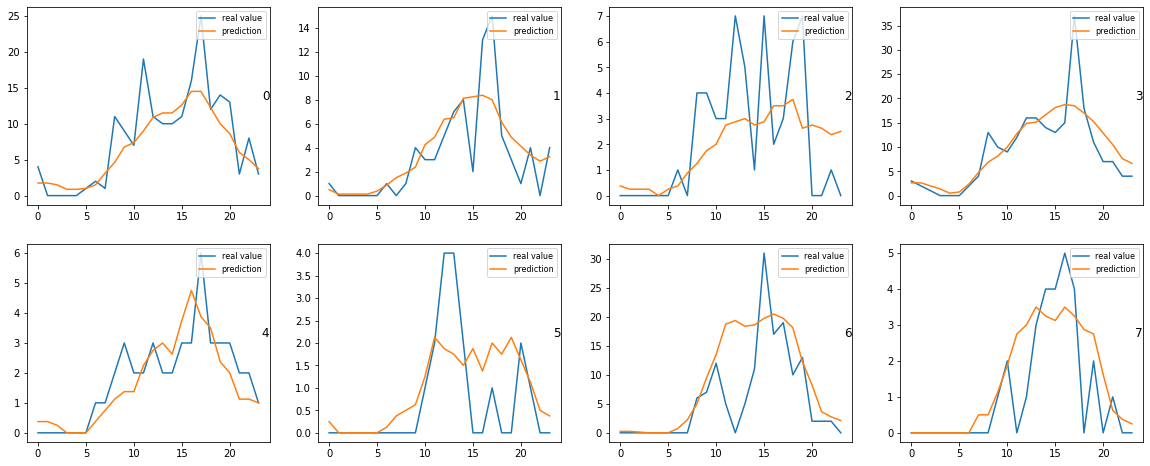

In [94]:
show_graph(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)),scaler_Y.inverse_transform(y_test.reshape(-1,1)))

## 决策回归树(手写)

In [ ]:
# 决策树
import math

class DecisionTree:
    def __init__(self,depth=99):
        self.depth = depth
        
    # 计算熵
    def infor_entropy(self,data):
        label = pd.Series(data)
        labelCount = label.value_counts()
        prob = labelCount/np.sum(labelCount)
        Entropy = 0
        for p in prob:
            Entropy = Entropy - (p*math.log2(p))
        return Entropy
    
    
    # 寻找最佳的划分方式
    def find_best_feature(self,x,y):
        baseEntropy = self.infor_entropy(y)
        bestInfoGain = 0.0
        col_selected = -1
        
        for col in x.keys():
            featurelist = x[col]
            uniqueFeature = featurelist.unique()
            newEntropy = 0
            for value in uniqueFeature:
                splitDataSet_y = y[x[col]==value]
                prob = len(splitDataSet_y) / len(y)
                newEntropy += prob * self.infor_entropy(splitDataSet_y)
            infoGain = baseEntropy - newEntropy # 信息增益
            if infoGain >= bestInfoGain:
                bestInfoGain = infoGain
                col_selected = col
        return col_selected

    def majorlabel(self, classlist):
        class_counts = classlist.value_counts()
        most_frequent = class_counts.idxmax()
        return most_frequent
        
    
    def createTree(self,x,y,mydepth):
         
        # 剪枝1：类别完全相同则停止划分
        if len(y.value_counts()) == 1:
            return y.iloc[0]
        
        # 剪枝2：若遍历完所有特征值仍无法完全分类，则返回出现次数最多的
        if len(x.keys())==0:
            return self.majorlabel(y)
        
        # 剪枝3：层数达到设定上限
        if (mydepth>self.depth):
            return self.majorlabel(y)
            
        # 选择最好的数据划分方式
        bestFeature = self.find_best_feature(x,y)
        myTree = {bestFeature:{}}
        featurevalue_x = x[bestFeature]
        uniqueFeature_x = featurevalue_x.unique()
        
        for value in uniqueFeature_x:
            sub_x = x[x[bestFeature]==value].copy()
            sub_x = sub_x.drop(labels=[bestFeature], axis=1)
            sub_y = y[x[bestFeature]==value].copy()
            myTree[bestFeature][value] = self.createTree(sub_x,sub_y,mydepth+1)
        return myTree
    
    def predict(self,tree,x_test, x_train, y_train):
#     key1:当前属性名称
#     key2:当前属性值
        for key1 in tree.keys():
            secondDict = tree[key1]
            for key2 in secondDict.keys():
                if x_test.loc[key1] == key2:
                    if type(secondDict[key2]).__name__ == "dict":
                        sub_x = x_train[x_train[key1]==key2].copy()
                        sub_y = y_train[x_train[key1]==key2].copy()
                        return self.predict(secondDict[key2], x_test,sub_x,sub_y)
                    else:
                        return secondDict[key2]
                        
            classlabel = self.majorlabel(y_train)
            
        return classlabel
    
    def fit(self, x_train, y_train):
        self.x = x_train
        self.y = y_train
        self.tree = self.createTree(self.x, self.y, 0)
    
    def score(self, x_test, y_test):
        y_pred=[]
        
        for i in range(x_test.shape[0]):
            label = self.predict(self.tree, x_test.iloc[i,:],self.x,self.y )
            y_pred.append(label)
        score_list = list(map(lambda x,y: 1 if x==y else 0, y_pred, y_test.values))
        score = round(sum(score_list)/len(score_list), 2)
        return score, y_pred

In [85]:
param_grid={'max_depth':[i for i in range(1,20)]}
myTree = GridSearchCV(DecisionTree(),param_grid,cv=10)
myTree.fit(x_train, y_train)

y_hat = myTree.predict(x_train)
y_hat_pred = myTree.predict(x_test)

print('Best_param;{}'.format(myTree.best_params_))

print("Train MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Train MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Test MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))
print("Test MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))

Best_param;{'max_depth': 9}
Train MSE:6.99760376
Train MAE:1.56067594
Test MSE:15.43411289
Test MAE:1.93585134


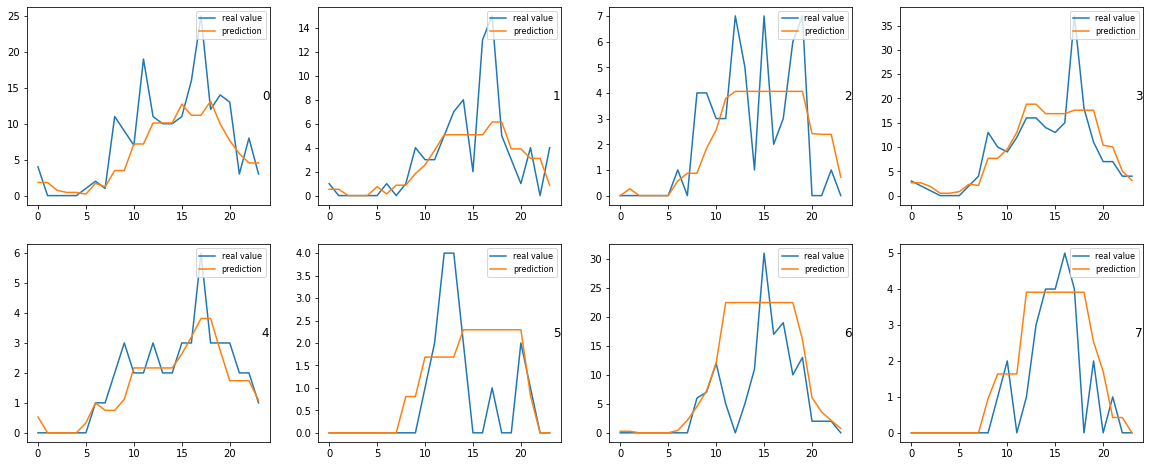

In [86]:
show_graph(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)),scaler_Y.inverse_transform(y_test.reshape(-1,1)))

## GBDT

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'n_estimators':[50,80,100,300]}

## 随机森林
GBDT = GridSearchCV(GradientBoostingRegressor(),param_grid, cv=2,scoring='accuracy')
GBDT.fit(x_train,y_train)

y_hat = GBDT.predict(x_train)
y_hat_pred = GBDT.predict(x_test)

print('Best_param;{}'.format(GBDT.best_params_))

print("Train MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Train MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Test MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))
print("Test MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))

Best_param;{'n_estimators': 80}
Train MSE:10.02919221
Train MAE:2.02142982
Test MSE:11.33727501
Test MAE:2.02056170


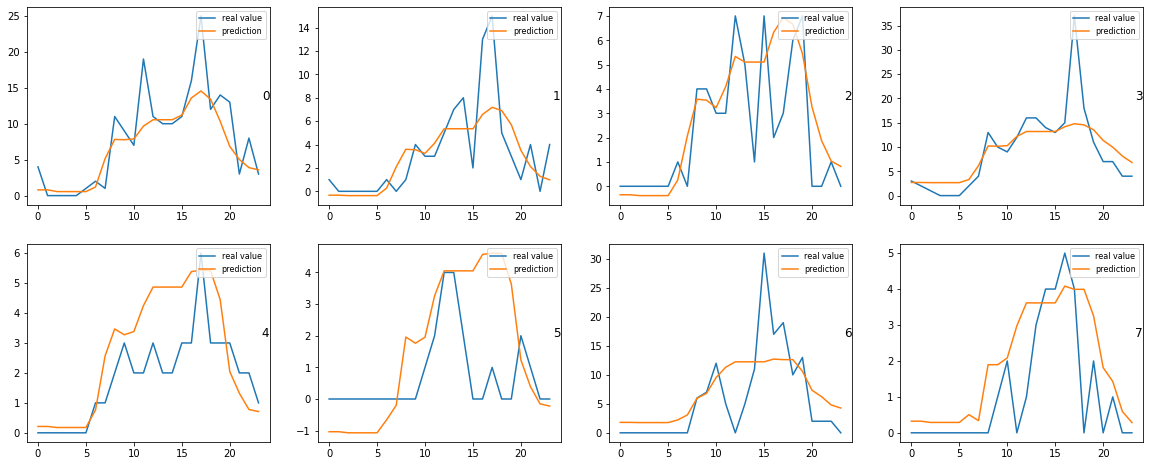

In [88]:
show_graph(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)),scaler_Y.inverse_transform(y_test.reshape(-1,1)))

## 随机森林

In [89]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {"n_estimators":[50,80,100,300]}

# 随机森林
clf = GridSearchCV(RandomForestRegressor(),param_grid, cv=10 ,scoring='accuracy')
clf.fit(x_train,y_train.ravel())

y_hat = clf.predict(x_train)
y_hat_pred = clf.predict(x_test)

print('Best_param;{}'.format(clf.best_params_))

print("Train MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Train MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Test MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))
print("Test MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))

Best_param;{'n_estimators': 50}
Train MSE:0.95086135
Train MAE:0.57732230
Test MSE:10.62777500
Test MAE:1.88187500


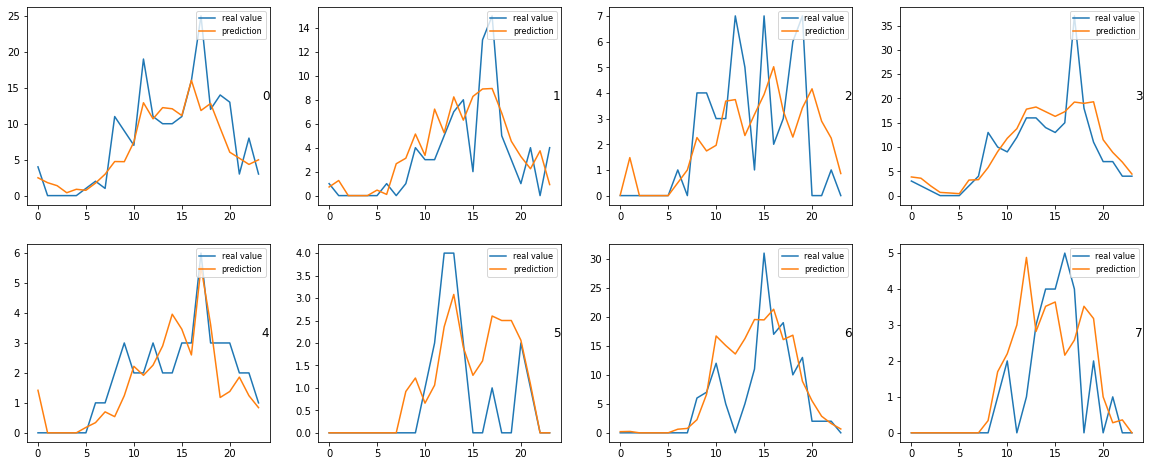

In [90]:
show_graph(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)),scaler_Y.inverse_transform(y_test.reshape(-1,1)))

## xgboost

In [91]:
from xgboost import XGBRegressor

param_grid = {"n_estimators":[50,80,100,300]}

# 随机森林
XGBR = GridSearchCV(XGBRegressor(),param_grid, cv=10 ,scoring='accuracy')
XGBR.fit(x_train,y_train.ravel())

y_hat = XGBR.predict(x_train)
y_hat_pred = XGBR.predict(x_test)

print('Best_param;{}'.format(XGBR.best_params_))

print("Train MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Train MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat.reshape(-1,1)), scaler_Y.inverse_transform(y_train.reshape(-1,1))))))
print("Test MSE:{:.8f}".format((mean_squared_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))
print("Test MAE:{:.8f}".format((mean_absolute_error(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)), scaler_Y.inverse_transform(y_test.reshape(-1,1))))))

Best_param;{'n_estimators': 80}
Train MSE:5.23166429
Train MAE:1.42731087
Test MSE:11.36940647
Test MAE:1.89084938


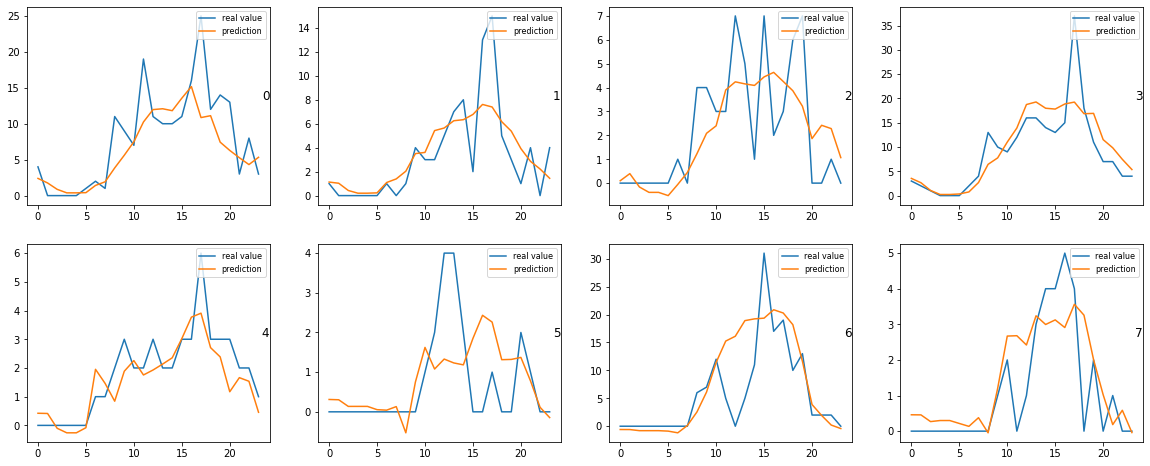

In [92]:
show_graph(scaler_Y.inverse_transform(y_hat_pred.reshape(-1,1)),scaler_Y.inverse_transform(y_test.reshape(-1,1)))